Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 108ms/step - accuracy: 0.5993 - loss: 1.7872 - precision: 0.7179 - recall: 0.4966 - val_accuracy: 0.2479 - val_loss: 2.3994 - val_precision: 0.4371 - val_recall: 0.0881 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 114ms/step - accuracy: 0.7171 - loss: 1.2566 - precision: 0.8095 - recall: 0.6296 - val_accuracy: 0.7291 - val_loss: 1.1439 - val_precision: 0.8194 - val_recall: 0.6275 - learning_rate: 0.0010
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.7532 - loss: 1.0440 - precision: 0.8248 - recall: 0.6757 - val_accuracy: 0.8094 - val_loss: 0.8449 - val_precision: 0.8712 - val_recall: 0.7523 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.7674 - loss: 0.9153 - precision: 0.8349 - recall: 0.7035 - val_accuracy: 0.7989 - val_loss: 0.7995 - val_precision: 0.8655 - val_recall: 0.7325 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 112ms/st

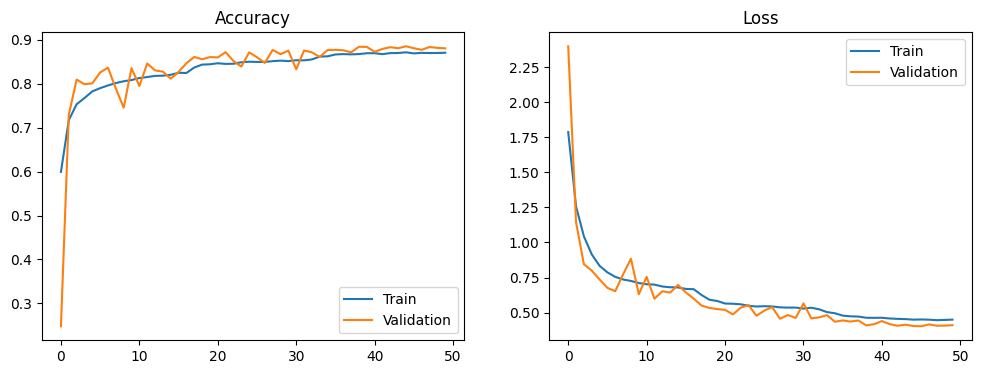


Model saved as final_enhanced_cnn_model.keras
Enhanced Model Test Accuracy: 0.8786


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

tf.random.set_seed(42)
np.random.seed(42)

class EnhancedCNNClassifier:
    """
    NOTE:
    Fashion-MNIST is used as a proxy dataset to validate the CNN architecture.
    The same model can later be trained on real CCTV frames.
    """
    def __init__(self, input_shape=(28, 28, 1), num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def create_augmentation_pipeline(self):
        return tf.keras.Sequential([
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.RandomContrast(0.2),
            layers.RandomTranslation(0.1, 0.1),
        ], name="data_augmentation")

    def build_final_model(self):
        augmentation = self.create_augmentation_pipeline()

        model = models.Sequential([
            layers.Input(shape=self.input_shape),
            augmentation,

            layers.Conv2D(32, 3, padding='same',
                          kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(),

            layers.Conv2D(64, 3, padding='same',
                          kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.3),

            layers.Conv2D(128, 3, padding='same',
                          kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Activation('relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.3),

            layers.Flatten(),
            layers.Dense(256, activation='relu',
                         kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),

            layers.Dense(128, activation='relu',
                         kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),

            layers.Dense(self.num_classes, activation='softmax')
        ])

        self.model = model
        return model

    def compile_model(self, learning_rate=0.001):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

    def train_model(self, x_train, y_train, x_val, y_val,
                    epochs=50, batch_size=128):

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5),
            tf.keras.callbacks.ModelCheckpoint(
                "best_model.keras", monitor='val_accuracy', save_best_only=True)
        ]

        self.history = self.model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        return self.history

    def evaluate_model(self, x_test, y_test):
        y_pred = self.model.predict(x_test)
        y_pred_cls = np.argmax(y_pred, axis=1)
        y_true_cls = np.argmax(y_test, axis=1)

        loss, acc, prec, rec = self.model.evaluate(x_test, y_test, verbose=0)
        f1 = 2 * (prec * rec) / (prec + rec + 1e-8)

        print("=" * 60)
        print("FINAL MODEL EVALUATION")
        print("=" * 60)
        print(f"Loss      : {loss:.4f}")
        print(f"Accuracy  : {acc:.4f}")
        print(f"Precision : {prec:.4f}")
        print(f"Recall    : {rec:.4f}")
        print(f"F1-Score  : {f1:.4f}")

        print("\nClassification Report:")
        print(classification_report(y_true_cls, y_pred_cls))

        return {"accuracy": acc, "precision": prec, "recall": rec}

    def selective_recording_simulation(self, x_data, threshold=0.8):
        preds = self.model.predict(x_data)
        confidences = np.max(preds, axis=1)
        record = confidences > threshold

        rate = record.mean() * 100
        print(f"\nThreshold: {threshold}")
        print(f"Frames recorded: {record.sum()}/{len(x_data)}")
        print(f"Recording rate: {rate:.2f}%")
        print(f"Storage saved: {100 - rate:.2f}%")

    def plot_training_history(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title("Accuracy")
        plt.legend(["Train", "Validation"])

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title("Loss")
        plt.legend(["Train", "Validation"])

        plt.show()


def main():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    x_train = x_train[..., None]
    x_test = x_test[..., None]

    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    split = int(0.8 * len(x_train))
    x_tr, x_val = x_train[:split], x_train[split:]
    y_tr, y_val = y_train[:split], y_train[split:]

    clf = EnhancedCNNClassifier()
    clf.build_final_model()
    clf.compile_model()

    clf.train_model(x_tr, y_tr, x_val, y_val)
    results = clf.evaluate_model(x_test, y_test)

    for t in [0.7, 0.8, 0.9]:
        clf.selective_recording_simulation(x_test[:1000], t)

    clf.plot_training_history()

    clf.model.save("final_enhanced_cnn_model.keras")
    print("\nModel saved as final_enhanced_cnn_model.keras")
    print(f"Enhanced Model Test Accuracy: {results['accuracy']:.4f}")


if __name__ == "__main__":
    main()
